## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from IPython.display import Image
import imageio
import os
import time
import pickle
from google.colab import files


tpu = True


In [ ]:
# Pour executer le code sur tpu :
# 1) Mettre tpu = True
# 2) Changer le type d'éxecution à TPU dans l'onglet execution
# 3) Lancer cette cellule avec la deuxieme ligne non commentée puis redemarrer l'environnement et commenter la ligne
if tpu:
    assert os.environ['COLAB_TPU_ADDR']
    !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
    import torch_xla
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
else:
    dev ='cpu'


     |████████████████████████████████| 149.9 MB 27 kB/s 
     |████████████████████████████████| 831.4 MB 2.4 kB/s 
     |████████████████████████████████| 57 kB 6.2 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9

ImportError: ignored

## Network Definition

### Layers

In [1]:
def build_generator(n_img,n_noise):
    # Encoder network
    generator = nn.Sequential(
        
        nn.Linear(n_noise, 128*7*7), 
        nn.Unflatten(1,(128,7,7)),
        
        nn.ConvTranspose2d(128,64, 3,stride=2,padding=1,output_padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(64, 32, 3,stride=1,padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(32,1, 3,stride=2,padding=1,output_padding=1),
        nn.Tanh(),
    )
    return generator

In [2]:
def build_discriminator(n_img,loss):
    # Encoder network
    discriminator = nn.Sequential(
        
        nn.Conv2d(1, 64, 3,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        
        nn.Conv2d(64,128, 3,stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Flatten(),
        nn.Linear(128*7*7,1))
    
    return discriminator

### Module Class


In [ ]:
class GAN(nn.Module):
    def __init__(self,flags):
        super().__init__()
        self.G = build_generator(flags['n_img'],flags['n_noise'])
        self.D = build_discriminator(flags['n_img'],flags['loss'])

    def generate(self, noise):
        return self.G(noise)#.view(-1, 1, 28, 28)
    def discriminate(self,image):
        x = image
        return self.D(x).view(-1,1)

### Data Loader

In [ ]:
def import_data(batch_size):
# Transforms to apply to the images
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
# Import the train dataset
  path = r'.\Dataset'
  trainset = torchvision.datasets.MNIST(root=path, train=True, download=True, transform=transform)
  if small_set==True:
    trainset, val_set = torch.utils.data.random_split(trainset, [2048, len(trainset)-2048])

  if tpu == True:
    train_sampler = torch.utils.data.distributed.DistributedSampler(trainset,
                                                                      num_replicas = xm.xrt_world_size(),
                                                                      rank         = xm.get_ordinal(),
                                                                      shuffle      = True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=flags['batch_size'],sampler=train_sampler,num_workers=0,pin_memory=True)
  else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=flags['batch_size'])

  return(trainloader)

### Some utility Functions

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
      
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def imshow(img,ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if ax==None:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()
    else:
      ax.imshow(np.transpose(npimg, (1, 2, 0)))
    
# save the generated images as GIF file
def save_gif(img_list):
    to_pil_image = transforms.ToPILImage()

    imgs = [np.array(to_pil_image(vutils.make_grid(img, padding=2))) for img in img_list]
    imageio.mimsave('./generator_images.gif', imgs)

def test_loader(trainloader):
# get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
# show images
    images.shape
    imshow(torchvision.utils.make_grid(images[:64]))
    plt.show()

In [ ]:
class MyHingeLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, output, target):
        return (torch.mean(torch.maximum(1 - torch.mul(output, target),0*target),0))

class MyLinearLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, output, target):
        return torch.mean(torch.mul(target,output),0)     

## Running Functions

### Initialisation

In [ ]:
def create_network(flags,dev):
  trainloader = import_data(flags['batch_size'])
  fixed_noise = torch.randn(64, flags['n_noise']).to(dev) #Fixed noise for evaluation of the samples

  my_gan = GAN(flags)
  my_gan = xmp.MpModelWrapper(my_gan).to(dev)
  
  my_gan.G.apply(weights_init)
  my_gan.D.apply(weights_init)

  if flags['loss'] =='mse':
    criterion1 = nn.MSELoss()
    criterion2 = criterion1
  if flags['loss'] == 'bce':
    criterion1 = nn.BCEWithLogitsLoss()
    criterion2 = criterion1
    
  if flags['loss']=='hinge':
    criterion1 = MyHingeLoss()
    criterion2 = MyLinearLoss()

  optimizerG = optim.Adam(my_gan.G.parameters(),lr=flags['lr'], betas=(0.5, 0.999))
  optimizerD = optim.Adam(my_gan.D.parameters(),lr=flags['lr'], betas=(0.5, 0.999))

  my_gan.D.train()
  my_gan.G.train()

  return(my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise)



### Training Loop

In [ ]:
def train(flags,my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise,dev):
  
  img_list,G_losses,D_losses = [],[],[]
  
  for epoch in range(flags['num_epochs']): 
        time_start = time.time()      
        D_loss,G_loss = 0.,0. #Variables for storing the losses

        # Select the DataLoader
        if tpu:
            para_loader = pl.ParallelLoader(trainloader, [dev])
            loader = para_loader.per_device_loader(dev)
        else:
            loader = trainloader

        iters = 0    
        for i, data in enumerate(loader):        
            current_bsize = data[0].shape[0]  

            #### TRAINING THE DISCRIMINATOR #####
            optimizerD.zero_grad()
            label_real = (flags['label_real'] + torch.zeros(current_bsize,1)).to(dev)
            label_fake = (flags['label_fake'] + torch.zeros(current_bsize,1)).to(dev) 
            #REAL DATA
            output_real = my_gan.discriminate(data[0])
            #TFAKE DATA
            noise = torch.randn(current_bsize, flags['n_noise']).to(dev)
            fakes = my_gan.generate(noise)
            output_fake = my_gan.discriminate(fakes)
            
            #COMPUTE LOSS
            errD_real = criterion1(output_real, label_real)
            errD_fake = criterion1(output_fake, label_fake)  

            errD_real.backward()
            errD_fake.backward()
            if tpu:
                xm.optimizer_step(optimizerD)
            else:
                optimizerD.step()

            #Saving the loss
            errD = errD_real + errD_fake
            D_loss+=errD.item()

            #### TRAINING THE GENERATOR #####
            optimizerG.zero_grad()
            label = (flags['label_real'] + torch.zeros(current_bsize,1)).to(dev)
            noise = torch.randn(current_bsize, flags['n_noise']).to(dev)
            fakes = my_gan.generate(noise)
            output = my_gan.discriminate(fakes)
            errG = criterion2(output, label)
            errG.backward()
            if tpu:
              xm.optimizer_step(optimizerG)
            else:
              optimizerG.step()
            G_loss+=errG.item()
            iters += 1
        
        #On calcule la loss moyennée sur le batch
        G_loss,D_loss = G_loss/(iters),D_loss/(iters)
        G_losses.append(G_loss)
        D_losses.append(D_loss)

        time_end = time.time()
        time_spent = time_end-time_start          
        xm.master_print('[%d/%d] \tTime Spent: %.4f \tLoss_D: %.4f   \tLoss_G:  %.4f'
                      % (epoch, flags['num_epochs'], time_spent,
                        D_loss, G_loss))
            
        with torch.no_grad():
            fakes = my_gan.generate(fixed_noise).cpu()
            img_list.append(fakes)
            
            if xm.is_master_ordinal() and epoch%20 == 0: # On montre les images toutes les 20 epochs
              image = vutils.make_grid(fakes.cpu(), padding=2, normalize=False)
              plt.figure()
              plt.axis("off")
              plt.title("Epoch : " + str(i) +" Image Generation")
              imshow(image)
              plt.show()
        
        if xm.is_master_ordinal() and epoch%20 == 0  or epoch==flags['num_epochs']-1: # On sauve les données et le modèle toutes les 20 epoches
          open_file = open('Outputs_'+flags['Simu_name']+'.pkl', "wb")
          pickle.dump([D_losses,G_losses,img_list], open_file)
          open_file.close()
  return(D_losses,G_losses,img_list)

In [ ]:
def map_fn(index,flags): #Map function pour le calcul multi-coeurs
  dev = xm.xla_device()
  torch.manual_seed(flags['seed'])
  my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise = create_network(flags,dev)
  D_losses,G_losses,img_list = train(flags,my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise,dev)
  

  open_file = open('Outputs_'+flags['Simu_name']+'.pkl', "wb")
  pickle.dump([D_losses,G_losses,img_list], open_file)
  open_file.close()

  open_file = open('Outputs_'+flags['Simu_name']+'_MODEL.pkl', "wb")
  pickle.dump(my_gan.cpu(), open_file)
  open_file.close()



## Train the model

In [ ]:
test = False
if test:
  dev = xm.xla_device()
  my_gan = GAN(flags)
  fixed_noise = torch.randn(8, flags['n_noise'])
  fake = my_gan.generate(fixed_noise)
  output = my_gan.discriminate(fake).to(dev)

[0/200] 	Time Spent: 29.3970 	Loss_D: 0.1088   	Loss_G:  4.0711


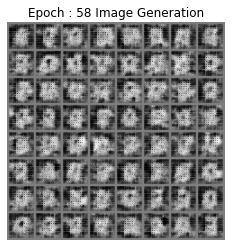

[1/200] 	Time Spent: 15.5762 	Loss_D: 0.0151   	Loss_G:  5.3077
[2/200] 	Time Spent: 16.0580 	Loss_D: 0.2369   	Loss_G:  5.4688
[3/200] 	Time Spent: 16.1336 	Loss_D: 0.0279   	Loss_G:  4.7138
[4/200] 	Time Spent: 16.1476 	Loss_D: 0.0274   	Loss_G:  4.6496
[5/200] 	Time Spent: 16.4926 	Loss_D: 0.6334   	Loss_G:  3.2439
[6/200] 	Time Spent: 16.2105 	Loss_D: 0.3342   	Loss_G:  2.9365
[7/200] 	Time Spent: 16.1747 	Loss_D: 0.5251   	Loss_G:  2.6437
[8/200] 	Time Spent: 16.2144 	Loss_D: 0.5719   	Loss_G:  2.4311
[9/200] 	Time Spent: 16.3419 	Loss_D: 0.5454   	Loss_G:  2.1691
[10/200] 	Time Spent: 16.0695 	Loss_D: 0.7224   	Loss_G:  2.0336
[11/200] 	Time Spent: 16.0856 	Loss_D: 0.7665   	Loss_G:  1.8038
[12/200] 	Time Spent: 16.4731 	Loss_D: 0.8278   	Loss_G:  1.5958
[13/200] 	Time Spent: 16.2587 	Loss_D: 0.9102   	Loss_G:  1.4965
[14/200] 	Time Spent: 16.1289 	Loss_D: 0.9203   	Loss_G:  1.3562
[15/200] 	Time Spent: 16.1284 	Loss_D: 0.9664   	Loss_G:  1.2880
[16/200] 	Time Spent: 16.1450 	Los

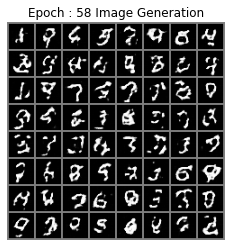

[21/200] 	Time Spent: 15.5125 	Loss_D: 1.0899   	Loss_G:  1.0316
[22/200] 	Time Spent: 16.0236 	Loss_D: 1.1184   	Loss_G:  1.0528
[23/200] 	Time Spent: 16.2508 	Loss_D: 1.1178   	Loss_G:  1.0220
[24/200] 	Time Spent: 16.1609 	Loss_D: 1.1067   	Loss_G:  0.9987
[25/200] 	Time Spent: 16.3840 	Loss_D: 1.1155   	Loss_G:  1.0069
[26/200] 	Time Spent: 16.2032 	Loss_D: 1.1154   	Loss_G:  1.0116
[27/200] 	Time Spent: 16.6673 	Loss_D: 1.1209   	Loss_G:  0.9916
[28/200] 	Time Spent: 16.3371 	Loss_D: 1.1208   	Loss_G:  1.0040
[29/200] 	Time Spent: 16.6853 	Loss_D: 1.1288   	Loss_G:  1.0010
[30/200] 	Time Spent: 16.5872 	Loss_D: 1.1295   	Loss_G:  1.0038
[31/200] 	Time Spent: 16.7639 	Loss_D: 1.1294   	Loss_G:  0.9980
[32/200] 	Time Spent: 16.6711 	Loss_D: 1.1087   	Loss_G:  0.9880
[33/200] 	Time Spent: 16.5067 	Loss_D: 1.1166   	Loss_G:  0.9967


In [ ]:
flags = {}
flags['Simu_name'] = 'BCE'
flags['loss'] = 'bce'
flags['label_real'] = 1
flags['label_fake'] = 0


flags['n_img'] = 28
flags['n_noise'] = 100
flags['lr'] = 0.0002
flags['batch_size'] = 128
flags['num_epochs']= 200
flags['seed'] = 1234
small_set = False

xmp.spawn(map_fn, args=(flags,), nprocs=8, start_method='fork')

## Results

In [ ]:
def plot_results(file,create_gif=False):
  open_file = open(file, "rb")
  [D_losses,G_losses,img_list] = pickle.load(open_file)
  open_file.close()

  # save_gif(img_list)
  f,ax = plt.subplots(1,1,figsize=(16,5))
  ax.plot(G_losses,label='Generator Loss')
  ax.plot(D_losses,label='Discriminator Loss')
  ax.legend()
  ax.set_xlabel('Epochs')

  plt.savefig('./loss.png')

  # Plot the fake images from the last epoch
  fakes = img_list[-1].cpu()
  images = vutils.make_grid(fakes, padding=2, normalize=False,nrow = 32)
  # Plot the fake images from the last epoch

  plt.figure(figsize=(16,4))
  plt.axis("off")
  plt.title("Last Epoch Image Generation")
  imshow(images)
  plt.show() 

def gif_trajectory(model_file):
    open_file = open(model_file, "rb")
    my_gan = pickle.load(open_file)
    open_file.close()
    noise =torch.randn(1, 100) 
    noise0 =torch.randn(1, 100) 
    img_list =[]
    noise_cur = noise
    for i in range(1000):
      if i%100==0:
        noise =torch.randn(1, 100) 
      noise_cur =  2*np.sin(2*np.pi/100*i)*noise + noise0
      fakes = my_gan.generate(noise_cur).detach()
      images = vutils.make_grid(fakes, padding=2, normalize=False,nrow=1)
      img_list.append(images)
      
    save_gif(img_list)


def plot_multiple_files(filenames):
  f,ax = plt.subplots(13,len(filenames),figsize=(28,45))

  for j,filename in enumerate(filenames):

    open_file = open(filename+'.pkl', "rb")
    [my_gan,D_losses,G_losses,accuracies1,accuracies2,img_list] = pickle.load(open_file).cpu()
    open_file.close()

    ax[0,j].set_title(filename)
    ax[0,j].plot(G_losses,label='Generator Loss')
    ax[0,j].plot(D_losses,label='Discriminator Loss')
    ax[0,j].legend()
    ax[0,j].set_xlabel('Epochs')

    nb_image=len(img_list)-1
    for i in range(1,11+1):
      
      index = (i - 1)*nb_image//11
      fakes = img_list[index].cpu()
      images = vutils.make_grid(fakes, padding=2, normalize=False,nrow=16)
      ax[i,j].axis("off")
      ax[i,j].set_title('Epoch = '+str(index))
      imshow(images,ax=ax[i,j])
      Image(url='.\generator_images.gif',width = 800, height = 500)           

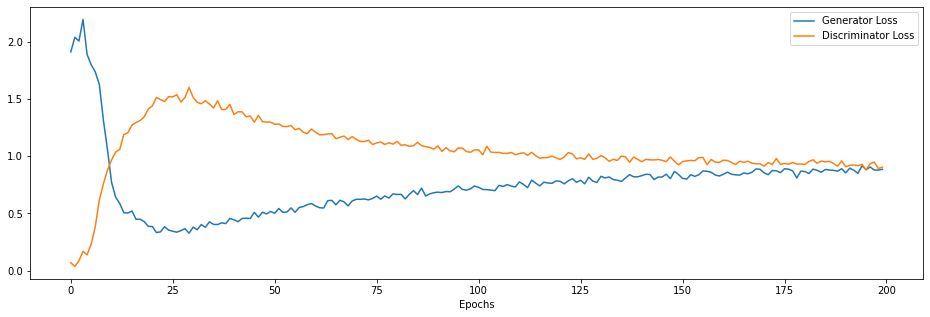

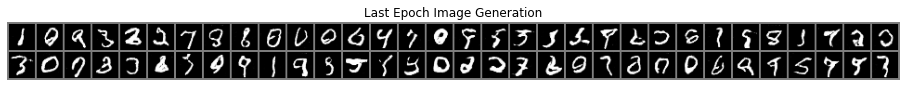

In [ ]:
plot_results('Outputs_HINGE.pkl')


In [ ]:
file = 'Outputs_HINGE_MODEL.pkl'
gif_trajectory(file)
files.download('./generator_gif.gif')


In [ ]:
filenames = ['Outputs_BCE_LOSS (1)','Outputs_MSE_LOSS','Outputs_HINGE']
plot_multiple_files(filenames)
